In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))


In [35]:
from sklearn import preprocessing
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from src.analysis.analysis import   main_analysis
from src.tools.preprocess import preprocess_data
import joblib
from sklearn.linear_model import LogisticRegression

In [36]:
from shapely.wkt import loads
data = pd.read_csv('../data/processed/data.csv')
data['area']= data["geometry"].apply( lambda polygon_wkt : loads(polygon_wkt).area)
#data['length']=  data["geometry"].apply(lambda polygon_wkt : loads(polygon_wkt).length)
#data['num_vertices']=  data["geometry"].apply(lambda polygon_wkt : loads(polygon_wkt).coords)
data['centroid_x']=  data["geometry"].apply(lambda polygon_wkt : loads(polygon_wkt).centroid.x)
data['centroid_y']=  data["geometry"].apply(lambda polygon_wkt : loads(polygon_wkt).centroid.y)
data.head()

,Unnamed: 0,FarmID,category,Crop,State,District,Sub-District,SDate,HDate,CropCoveredArea,...,tif_path,ndvi,evi,ndwi,gndvi,savi,msavi,area,centroid_x,centroid_y
0,0,1326576,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-25 0:00:00,2024-04-14 0:00:00,97,...,downloads/20240412T050649_20240412T051727_T43Q...,0.100756,-0.793684,8.488031,0.127153,0.151125,4232.596191,9.956528e-07,78.181592,17.978863
1,1,1326577,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-11-13 0:00:00,2024-04-26 0:00:00,82,...,downloads/20240425T051649_20240425T052817_T43Q...,0.188090,0.564248,11.493762,0.187815,0.282110,3249.392822,1.497475e-06,78.175606,17.980966
2,2,1326578,Healthy,Paddy,Telangana,Medak,Kulcharam,2023-12-19 0:00:00,2024-04-28 0:00:00,92,...,downloads/20240427T050651_20240427T051439_T43Q...,0.206596,-1.456745,10.166884,0.206553,0.309869,3741.956055,9.668150e-07,78.169207,17.976084
3,3,1331836,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-02-11 0:00:00,2024-11-04 0:00:00,91,...,downloads/20241103T050951_20241103T052004_T43Q...,0.206250,2.206184,10.446196,0.220995,0.309350,3673.396729,1.186327e-06,78.169059,17.974588
4,4,1326579,Diseased,Paddy,Telangana,Medak,Kulcharam,2023-12-12 0:00:00,2024-05-19 0:00:00,94,...,downloads/20240517T050651_20240517T051655_T43Q...,0.179721,-0.743638,8.665929,0.160657,0.269563,4227.338379,5.810344e-07,78.172695,17.969159


/home/paul/code/python/zindi/AAIS-AI/zindi_telangana_crop_health_challenge/src/tools/preprocess.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3943.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_clean.loc[non_null_mask & outlier_mask, col] = clean_mean
/home/paul/code/python/zindi/AAIS-AI/zindi_telangana_crop_health_challenge/src/tools/preprocess.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1301674.4039252088' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_clean.loc[non_null_mask & outlier_mask, col] = clean_mean
/home/paul/code/python/zindi/AAIS-AI/zindi_telangana_crop_health_challenge/src/tools/preprocess.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future ve


Variables numériques significativement associées à la catégorie (p < 0.05):
- CropCoveredArea: p-value = 0.0000
- WaterCov: p-value = 0.0142
- ndvi: p-value = 0.0099
- gndvi: p-value = 0.0066
- savi: p-value = 0.0131
- SDate_month: p-value = 0.0086
- HDate_year: p-value = 0.0003

Variables catégorielles significativement associées à la catégorie (p < 0.05):
- Crop: p-value = 0.0001
- District: p-value = 0.0000
- IrriType: p-value = 0.0007
- IrriSource: p-value = 0.0006
- Season: p-value = 0.0026


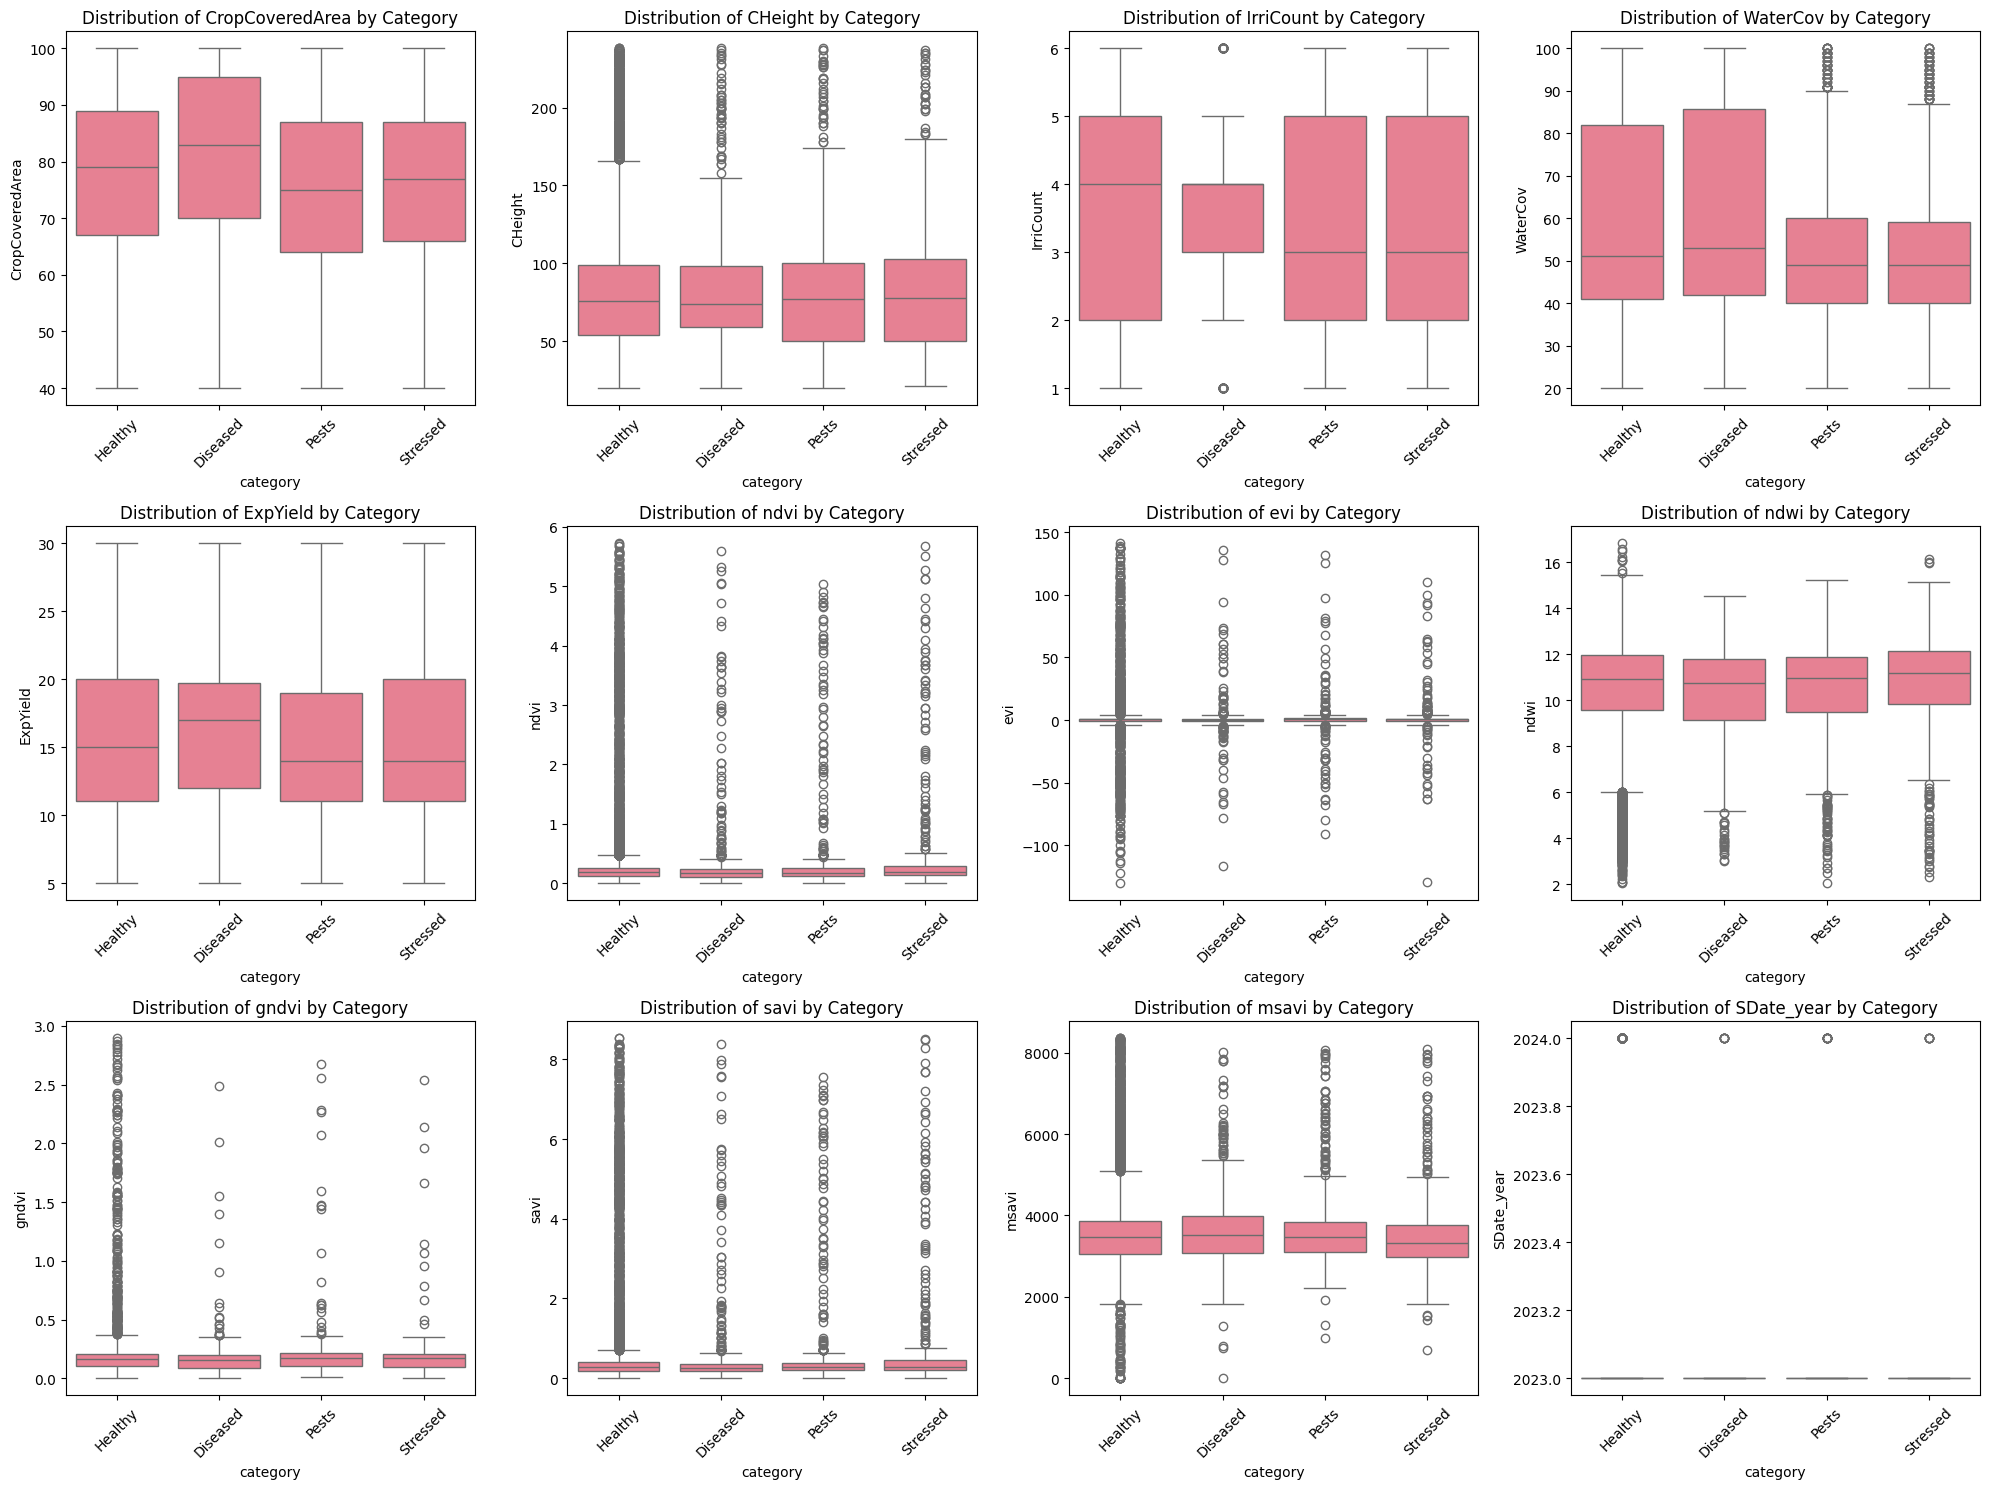

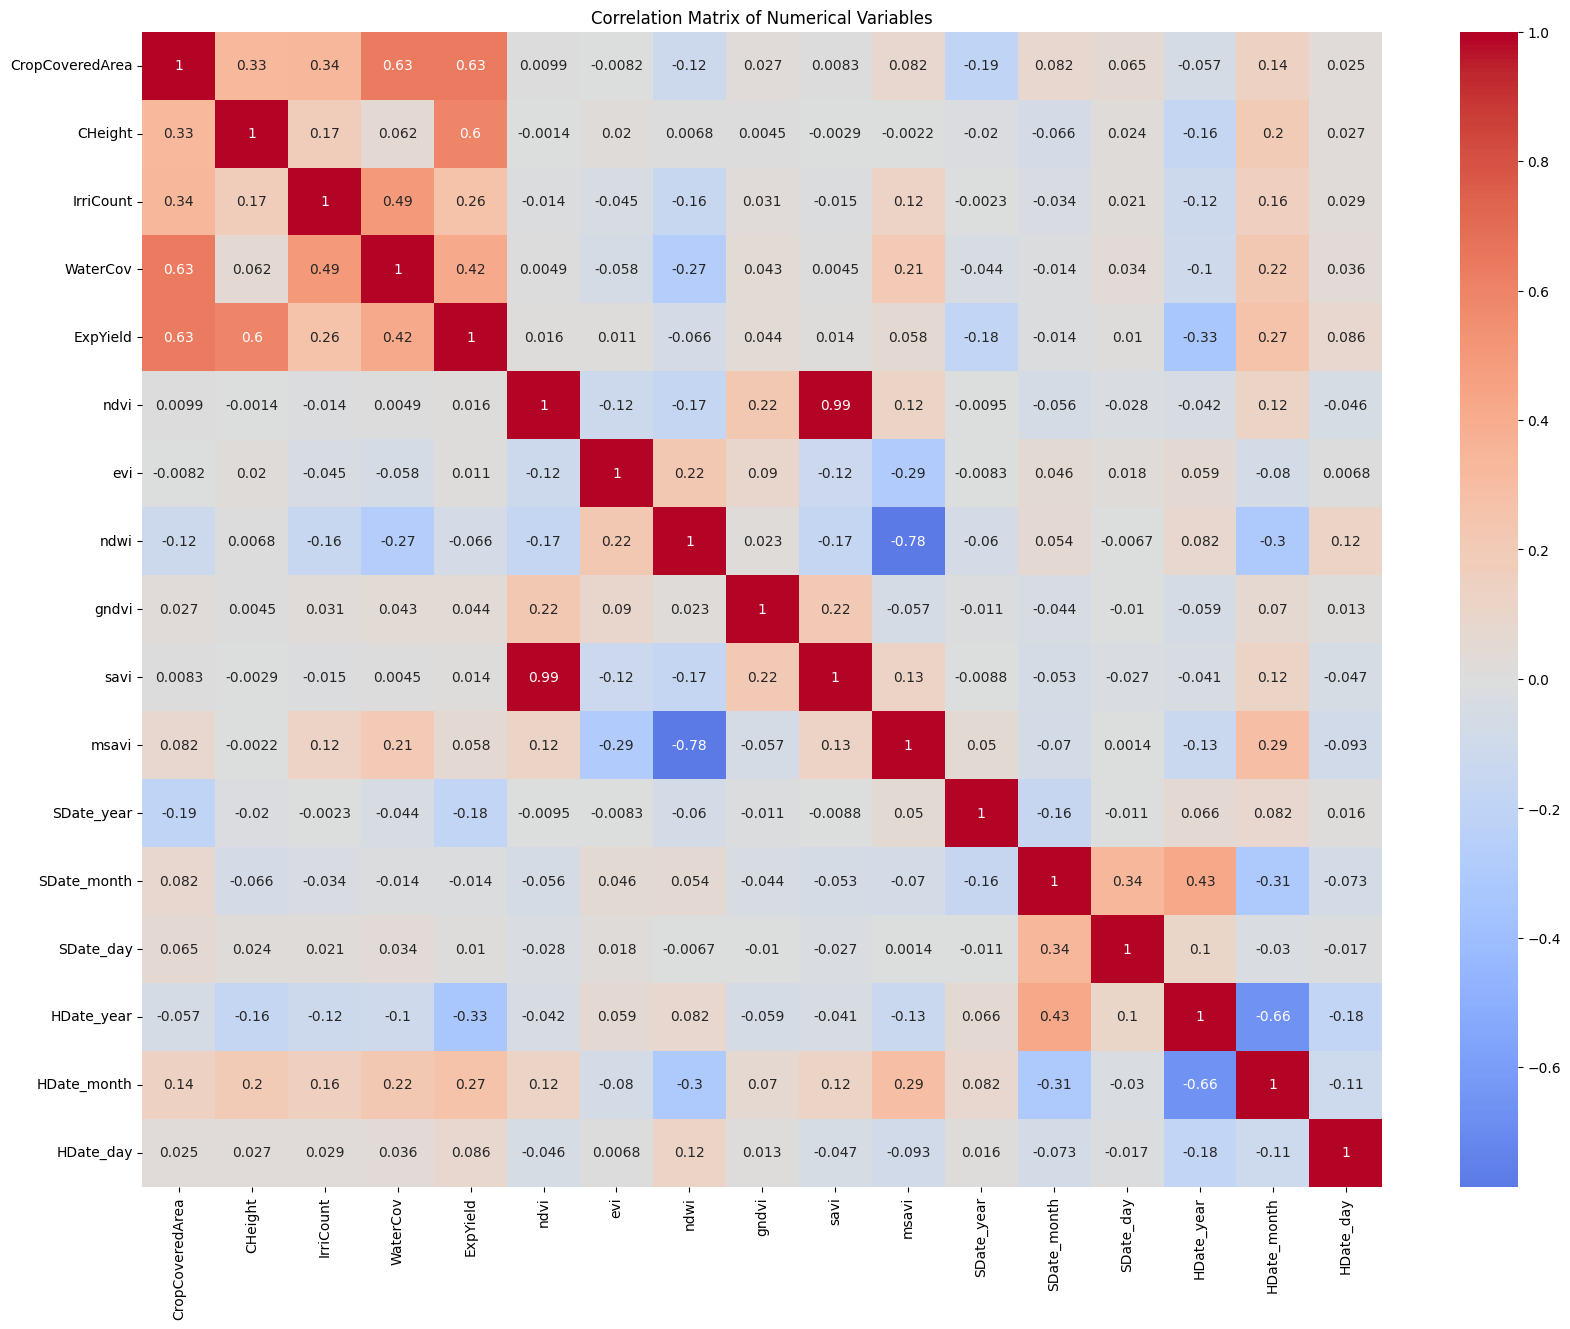

In [4]:
data_clean, anomalies = preprocess_data(data[data["dataset"]=="train"])
analysis_resulults = main_analysis(data_clean)

In [34]:
data_clean.columns

Index(['Unnamed: 0', 'FarmID', 'category', 'Crop', 'State', 'District',
       'Sub-District', 'SDate', 'HDate', 'CropCoveredArea', 'CHeight', 'CNext',
       'CLast', 'CTransp', 'IrriType', 'IrriSource', 'IrriCount', 'WaterCov',
       'ExpYield', 'Season', 'geometry', 'dataset', 'tif_path', 'ndvi', 'evi',
       'ndwi', 'gndvi', 'savi', 'msavi', 'area', 'centroid_x', 'centroid_y',
       'SDate_year', 'SDate_month', 'SDate_day', 'HDate_year', 'HDate_month',
       'HDate_day'],
      dtype='object')

In [2]:
feature_columns = [
    'CropCoveredArea', 'CHeight', 'IrriCount', 'WaterCov', 'ExpYield',
    'ndvi', 'evi', 'ndwi', 'gndvi', 'savi', 'msavi', 'SDate_year', 'SDate_month',
       'SDate_day', 'HDate_year', 'HDate_month', 'HDate_day','centroid_y', 'centroid_x','area'
]

X = data_clean[feature_columns]
y = data_clean['category']
enc = preprocessing.OneHotEncoder()
le = LabelEncoder()
y = le.fit_transform(y)
for i in range(4):
    print(f"classe {i} : {(y==i).sum()/y.sum():2.2%}")
le.classes_

NameError: name 'data_clean' is not defined

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [43]:
load_model = False
if load_model:
    best_lenear_model = joblib.load('best_svm_model.joblib')
else:
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear', "sigmoid","poly"],
        'gamma': ['scale', 'auto', 0.1, 0.01]
    }
    svm = SVC(random_state=42)
    grid_search = GridSearchCV(
        svm, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train)
    best_lenear_model = grid_search.best_estimator_
    cv_scores = cross_val_score(
        best_lenear_model, X_train, y_train, cv=5, scoring='f1_macro'
    )
    
    cv_scores

Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [41]:
load_model = False
if load_model:
    best_lenear_model = joblib.load('best_svm_model.joblib')
else:
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto', 0.1, 0.01]
    }
    svm = SVC(random_state=42)
    grid_search = GridSearchCV(
        svm, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train)
    best_lenear_model = grid_search.best_estimator_
    cv_scores = cross_val_score(
        best_lenear_model, X_train, y_train, cv=5, scoring='f1_macro'
    )
    
    cv_scores

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [44]:

y_pred = best_lenear_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.06      0.07      0.06        87
           1       0.83      0.87      0.85      1305
           2       0.02      0.01      0.01        84
           3       0.09      0.04      0.05       102

    accuracy                           0.73      1578
   macro avg       0.25      0.25      0.25      1578
weighted avg       0.70      0.73      0.71      1578



In [45]:
#save model
joblib.dump(best_lenear_model, 'best_svm_model1.joblib')

['best_svm_model1.joblib']

In [14]:

log_reg = LogisticRegression( solver='lbfgs', max_iter=2000, class_weight='balanced')

param_grid = {
    'C': [0.1, 1, 10, 100], 
}
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)


best_logistic_model = grid_search.best_estimator_


y_pred = best_logistic_model.predict(X_test)

print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("Rapport de classification :\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


Matrice de confusion :
 [[ 45  11  13  18]
 [414 197 342 352]
 [ 13  15  32  24]
 [ 23   9  33  37]]
Rapport de classification :
               precision    recall  f1-score   support

           0       0.09      0.52      0.15        87
           1       0.85      0.15      0.26      1305
           2       0.08      0.38      0.13        84
           3       0.09      0.36      0.14       102

    accuracy                           0.20      1578
   macro avg       0.28      0.35      0.17      1578
weighted avg       0.72      0.20      0.24      1578



In [34]:
test_encoded = pd.read_csv("../data/processed/data.csv")

test_encoded = test_encoded[test_encoded["dataset"]=="test"]
test_encoded['FarmID'] = test_encoded["FarmID"].astype(str)
test_encoded.drop(columns=["category"], inplace=True)
test_encoded, anomalies = preprocess_data(test_encoded)

feature_columns = [
    'CropCoveredArea', 'CHeight', 'IrriCount', 'WaterCov', 'ExpYield',
    'ndvi', 'evi', 'ndwi', 'gndvi', 'savi', 'msavi', 'SDate_year', 'SDate_month',
       'SDate_day', 'HDate_year', 'HDate_month', 'HDate_day',#'centroid_y', 'centroid_x','area'
]
X_test_submission =test_encoded[feature_columns]
X_test_submission = scaler.transform(X_test_submission)




test_predictions = best_lenear_model.predict(X_test_submission)
test_predictions_decoded = le.inverse_transform(test_predictions)

sample_submission = pd.DataFrame()
sample_submission['ID'] = test_encoded["FarmID"].astype(str)  # Convertir en chaîne de caractères
sample_submission['Target'] = test_predictions_decoded

# Aperçu du DataFrame
sample_submission.head()

# Sauvegarder le fichier de soumission
sample_submission.to_csv('submission_1.csv', index=False)

/home/paul/code/python/zindi/AAIS-AI/zindi_telangana_crop_health_challenge/src/tools/preprocess.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9246.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_clean.loc[non_null_mask & outlier_mask, col] = clean_mean
/home/paul/code/python/zindi/AAIS-AI/zindi_telangana_crop_health_challenge/src/tools/preprocess.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '77.80242825607064' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_clean.loc[non_null_mask & outlier_mask, col] = clean_mean
/home/paul/code/python/zindi/AAIS-AI/zindi_telangana_crop_health_challenge/src/tools/preprocess.py:58: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future ver